In [307]:
import os
import numpy as np
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.kernel_ridge import KernelRidge
from mlxtend.preprocessing import minmax_scaling
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.linear_model import LinearRegression

from lazypredict.Supervised import LazyRegressor
from sklearn import datasets
from sklearn.utils import shuffle

BOHR_TO_ANGSTROM = 0.529177


#ref = get_local_charges(open("6_charges_refined.xyz").readlines()[2:8])


In [40]:
def get_geometry_from_lines(lines):
    a,b,c = lines
    O = np.array([float(x) for x in a.split()[2:]])
    H1 = np.array([float(x) for x in b.split()[2:]])
    H2 = np.array([float(x) for x in c.split()[2:]])
    r2 = distance.euclidean(O, H1)*BOHR_TO_ANGSTROM
    r3 = distance.euclidean(O, H2)*BOHR_TO_ANGSTROM
    ba = H1 - O
    bc = H2 - O

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    a3 = np.degrees(np.arccos(cosine_angle))
    
    return O, H1, H2, r2, r3, a3

def get_local_charges(lines):
    tmp_dict = {}
    n_lines = len(lines)
    charges = np.array([ [float(x.split()[1]),
              float(x.split()[2]),
              float(x.split()[3]),
              float(x.split()[4])] for x in lines])

    for i, axis in enumerate(["x", "y", "z", "q"]):
        for c in range(n_lines):
            if f"{axis}_c{c}" not in tmp_dict.keys():
                tmp_dict[f"{axis}_c{c}"] = charges[c,i]
            
            
    return tmp_dict

In [353]:
data_dict = {"frame": [], "O": [], "H1": [], "H2": [], "r2": [], "r3": [], "a3": []}
local_dicts = []

raw_files = [x for x in os.listdir(".") if x.endswith("raw") and x.__contains__("traj1000_")]

# raw_files = [raw_files[0], raw_files[3]]

for raw_file in raw_files:
    print(raw_file)
    
    lines = open(raw_file).readlines()

    for i, l in enumerate(lines):
        if l.startswith("frame"):
            fail = False
            xyz = lines[i+7:i+10]
            try:
                O, H1, H2, r2, r3, a3 = get_geometry_from_lines(xyz)
            except:
#                 print(i, l, xyz)
#                 print(lines[i:i+19])
                fail = True

            try:
                charges_dict = get_local_charges(lines[i+13:i+19])
            except:
#                 print(i, l, lines[i+13:i+19])
                fail = True
    
            if r2 < 0.1:
                fail = True

            if not fail:
                data_dict["frame"].append(l)
                data_dict["O"].append(O)
                data_dict["H1"].append(H1)
                data_dict["H2"].append(H2)
                data_dict["r2"].append(r2)
                data_dict["r3"].append(r3)
                data_dict["a3"].append(a3)
                local_dicts.append(charges_dict)



traj1000_169.raw
traj1000_112.raw
traj1000_13.raw
traj1000_311.raw


In [354]:
df = pd.DataFrame(data_dict)
local_df = pd.DataFrame(local_dicts)
local_df_xyz_keys = [x for x in list(local_df.keys()) if not x.startswith("q")]

ref_local_df = pd.DataFrame(ref)
ref_local_df = pd.DataFrame(local_df.iloc[1,:]).T

ref_local_df = ref_local_df.append([ref_local_df]*(len(list(df.iterrows()))-1) ,ignore_index=True)

ref_local_df

,x_c0,x_c1,x_c2,x_c3,x_c4,x_c5,y_c0,y_c1,y_c2,y_c3,...,z_c2,z_c3,z_c4,z_c5,q_c0,q_c1,q_c2,q_c3,q_c4,q_c5
0,0.06,0.10,0.30,-0.33,0.31,-0.02,-0.51,0.45,-0.00,-0.01,...,0.06,0.27,-0.12,-0.04,-0.28,-0.31,0.20,0.09,0.06,0.24
1,0.06,0.10,0.30,-0.33,0.31,-0.02,-0.51,0.45,-0.00,-0.01,...,0.06,0.27,-0.12,-0.04,-0.28,-0.31,0.20,0.09,0.06,0.24
2,0.06,0.10,0.30,-0.33,0.31,-0.02,-0.51,0.45,-0.00,-0.01,...,0.06,0.27,-0.12,-0.04,-0.28,-0.31,0.20,0.09,0.06,0.24
3,0.06,0.10,0.30,-0.33,0.31,-0.02,-0.51,0.45,-0.00,-0.01,...,0.06,0.27,-0.12,-0.04,-0.28,-0.31,0.20,0.09,0.06,0.24
4,0.06,0.10,0.30,-0.33,0.31,-0.02,-0.51,0.45,-0.00,-0.01,...,0.06,0.27,-0.12,-0.04,-0.28,-0.31,0.20,0.09,0.06,0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,0.06,0.10,0.30,-0.33,0.31,-0.02,-0.51,0.45,-0.00,-0.01,...,0.06,0.27,-0.12,-0.04,-0.28,-0.31,0.20,0.09,0.06,0.24
404,0.06,0.10,0.30,-0.33,0.31,-0.02,-0.51,0.45,-0.00,-0.01,...,0.06,0.27,-0.12,-0.04,-0.28,-0.31,0.20,0.09,0.06,0.24
405,0.06,0.10,0.30,-0.33,0.31,-0.02,-0.51,0.45,-0.00,-0.01,...,0.06,0.27,-0.12,-0.04,-0.28,-0.31,0.20,0.09,0.06,0.24
406,0.06,0.10,0.30,-0.33,0.31,-0.02,-0.51,0.45,-0.00,-0.01,...,0.06,0.27,-0.12,-0.04,-0.28,-0.31,0.20,0.09,0.06,0.24


In [355]:
df

,frame,O,H1,H2,r2,r3,a3
0,frame_169\n,"[0.0, 0.24292, 0.0]","[1.28597, -0.876276, 0.0]","[-1.28597, -1.067083, 0.0]",0.90,0.97,93.44
1,frame_170\n,"[0.0, 0.257757, 0.0]","[1.373172, -0.928284, 0.0]","[-1.373172, -1.133771, 0.0]",0.96,1.03,93.80
2,frame_171\n,"[0.0, 0.229048, 0.0]","[1.360723, -0.821822, 0.0]","[-1.360723, -1.010558, 0.0]",0.91,0.97,99.99
3,frame_172\n,"[0.0, 0.225966, 0.0]","[1.515884, -0.837702, 0.0]","[-1.515884, -0.970028, 0.0]",0.98,1.02,106.67
4,frame_173\n,"[0.0, 0.198653, 0.0]","[1.482109, -0.776328, 0.0]","[-1.482109, -0.812892, 0.0]",0.94,0.95,112.35
...,...,...,...,...,...,...,...
403,frame_408\n,"[0.0, 0.227246, 0.0]","[1.497128, -0.901355, 0.0]","[-1.497128, -0.916615, 0.0]",0.99,1.00,105.61
404,frame_409\n,"[0.0, 0.222282, 0.0]","[1.488258, -0.918815, 0.0]","[-1.488258, -0.859443, 0.0]",0.99,0.97,106.51
405,frame_410\n,"[0.0, 0.211289, 0.0]","[1.458821, -0.870763, 0.0]","[-1.458821, -0.819551, 0.0]",0.96,0.95,108.19
406,frame_411\n,"[0.0, 0.213498, 0.0]","[1.483447, -0.873578, 0.0]","[-1.483447, -0.834406, 0.0]",0.97,0.96,108.53


In [447]:
adjusted_local = local_df - ref_local_df
adjusted_local

,x_c0,x_c1,x_c2,x_c3,x_c4,x_c5,y_c0,y_c1,y_c2,y_c3,...,z_c2,z_c3,z_c4,z_c5,q_c0,q_c1,q_c2,q_c3,q_c4,q_c5
0,0.02,0.03,0.01,0.00,0.00,0.01,0.01,-0.00,0.00,0.00,...,0.01,-0.00,-0.00,-0.01,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.03,0.03,-0.01,0.01,0.01,0.01,-0.00,0.00,0.00,-0.00,...,0.02,0.01,-0.02,-0.03,0.00,0.00,0.00,0.00,0.00,0.00
3,0.04,0.03,0.01,0.03,0.03,0.04,0.00,0.00,0.00,-0.00,...,0.04,0.02,-0.03,-0.04,0.00,0.00,0.00,0.00,0.00,0.00
4,0.08,0.06,0.01,0.04,0.04,0.05,0.01,-0.00,0.00,-0.00,...,0.06,0.03,-0.05,-0.07,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,0.07,0.02,-0.01,0.12,0.28,-0.03,0.03,-0.01,0.00,0.02,...,-0.01,0.09,0.02,-0.08,0.00,0.00,0.00,0.00,0.00,0.00
404,0.07,0.03,-0.01,0.12,0.28,-0.03,0.03,-0.01,0.00,0.02,...,-0.00,0.09,0.01,-0.08,0.00,0.00,0.00,0.00,0.00,0.00
405,0.09,0.04,-0.01,0.13,0.28,-0.03,0.03,-0.01,0.00,0.02,...,0.01,0.09,0.01,-0.09,0.00,0.00,0.00,0.00,0.00,0.00
406,0.08,0.04,-0.01,0.13,0.29,-0.02,0.03,-0.01,0.00,0.02,...,0.01,0.09,0.01,-0.09,0.00,0.00,0.00,0.00,0.00,0.00


In [448]:
df["bond_sum"] = df["r2"] + df["r3"]
df["bond_sum_scaled"] = minmax_scaling(df["bond_sum"], columns=[0])
df["bond_sum_norm"] = stats.boxcox(df["bond_sum"])[0]

df["a3_scaled"] = minmax_scaling(df["a3"], columns=[0])
df["a3_norm"] = stats.boxcox(df["a3"])[0]

df["r2_scaled"] = minmax_scaling(df["r2"], columns=[0])
df["r2_norm"] = stats.boxcox(df["r2"])[0]

df["r3_scaled"] = minmax_scaling(df["r3"], columns=[0])
df["r3_norm"] = stats.boxcox(df["r3"])[0]

for i in range(6):
    y = adjusted_local[[f"x_c{i}", f"y_c{i}", f"z_c{i}"]].values
    print(abs(y).sum())

46.265528799198854
15.635728106491545
16.79000307276166
67.09700216251207
86.26052067898524
39.050924494736044


In [457]:
#y = local_df[["y_c0"]].values
# y = adjusted_local[local_df_xyz_keys].values
models_list = []
KRR_list = []
KRR_cross_val_scores = []
GPR_cross_val_scores = []
ridgeCV_cross_val_scores = []
reg_cross_val_scores = []
cross_folds_max = 10
cross_folds_step = 5

for i in range(6):
    KRR_cross_val_scores.append([])
    GPR_cross_val_scores.append([])
    ridgeCV_cross_val_scores.append([])
    reg_cross_val_scores.append([])

    for cross_folds in range(2, cross_folds_max, cross_folds_step):
#     for cross_folds in [1]:
        y = adjusted_local[[f"x_c{i}", f"y_c{i}", f"z_c{i}"]].values
        #y = adjusted_local[local_df_xyz_keys].values

        X = df[["r2_scaled", "a3_scaled", "r3_scaled"]].values

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    #     reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
    #     models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    #     print(models.__dict__)
    #     models_list.append(models)

        kernel = DotProduct() #+ WhiteKernel()
        gpr = GaussianProcessRegressor(kernel=kernel, 
                                       random_state=0).fit(X_train, y_train)
        scores = cross_val_score(gpr, X, y, cv=cross_folds)
        GPR_cross_val_scores[-1].append(scores)

        reg = LinearRegression().fit(X_train, y_train)
        scores = cross_val_score(reg, X, y, cv=cross_folds)
        reg_cross_val_scores[-1].append(scores)


        clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, X_train)
        scores = cross_val_score(clf, X, y, cv=cross_folds)
        ridgeCV_cross_val_scores[-1].append(scores)

        krr = KernelRidge(alpha=1.0)
        krr.fit(X_train,y_train)
        scores = cross_val_score(krr, X, y, cv=cross_folds)
        KRR_cross_val_scores[-1].append(scores)


In [458]:
# print(models_list)
# print(KRR_list)
means = [np.mean(x) for x in GPR_cross_val_scores[0]]
# print([np.mean(x) for x in reg_cross_val_scores])
# print([np.mean(x) for x in KRR_cross_val_scores])
# print([np.mean(x) for x in ridgeCV_cross_val_scores])


Text(0.5, 0, '$k$-crossfold validation')

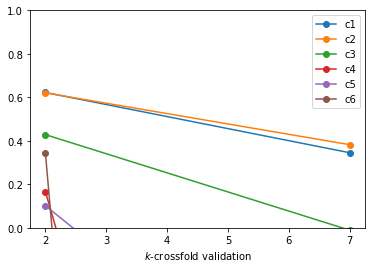

In [459]:
for i in range(6):
    plt.plot(list(range(2, cross_folds_max, cross_folds_step)), 
             [np.mean(x) for x in GPR_cross_val_scores[i]], "-o", label=f"c{i+1}")
plt.ylim(0, 1)
plt.legend()
plt.xlabel("$k$-crossfold validation")
# plt.xlim(0, 100)

In [452]:
[np.mean(x) for x in GPR_cross_val_scores[0]]
# list(range(2, cross_folds_max, cross_folds_step))

[0.6223415674493352]

In [250]:
#y = local_df[["y_c0"]].values
# y = adjusted_local[local_df_xyz_keys].values

models_list = []
KRR_list = []
KRR_cross_val_scores = []
ridgeCV_cross_val_scores = []

for i in range(6):
    y = local_df[[f"x_c{i}", f"y_c{i}", f"z_c{i}"]].values
    X = df[["bond_sum", "a3", "r3"]].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
    models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    print(models.__dict__)
    models_list.append(models)
    
    clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X, y)
    scores = cross_val_score(clf, X, y, cv=5)
    ridgeCV_cross_val_scores.append(scores)

    krr = KernelRidge(alpha=1.0)
    krr.fit(X_train,y_train)
    scores = cross_val_score(krr, X_test, y_test, cv=5)
    KRR_cross_val_scores.append(scores)
    KRR_list.append(krr.score(X_test, y_test))

 21%|█████████▍                                  | 9/42 [00:00<00:00, 71.93it/s]

AdaBoostRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
BayesianRidge model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
ElasticNetCV model failed to execute
For multi-task outputs, use MultiTaskElasticNetCV
GammaRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
GeneralizedLinearRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
GradientBoostingRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
HistGradientBoostingRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
HuberRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.


 81%|██████████████████████████████████▊        | 34/42 [00:00<00:00, 81.09it/s]

LarsCV model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
LassoCV model failed to execute
For multi-task outputs, use MultiTaskLassoCV
LassoLarsCV model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
LassoLarsIC model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
LinearSVR model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
NuSVR model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
OrthogonalMatchingPursuitCV model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
PassiveAggressiveRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
PoissonRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.


  0%|                                                    | 0/42 [00:00<?, ?it/s]

SGDRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
SVR model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
TweedieRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
XGBRegressor model failed to execute
y_true and y_pred have different number of output (3!=1)
LGBMRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
{'_is_copy': None, '_data': BlockManager
Items: Index(['Adjusted R-Squared', 'R-Squared', 'RMSE', 'Time Taken'], dtype='object')
Axis 1: Index(['Lars', 'TransformedTargetRegressor', 'LinearRegression',
       'RANSACRegressor', 'RidgeCV', 'Ridge', 'ExtraTreesRegressor',
       'RandomForestRegressor', 'OrthogonalMatchingPursuit',
       'KNeighborsRegressor', 'BaggingRegressor', 'ExtraTreeRegressor',
       'DecisionTreeRegressor', 'LassoLars', 'DummyRegressor', 'ElasticNet',
       'Lasso', 'MLPRegre

 52%|██████████████████████▌                    | 22/42 [00:00<00:00, 95.00it/s]

GammaRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
GeneralizedLinearRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
GradientBoostingRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
HistGradientBoostingRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
HuberRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
LarsCV model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
LassoCV model failed to execute
For multi-task outputs, use MultiTaskLassoCV
LassoLarsCV model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
LassoLarsIC model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
LinearSVR model failed to execute
y should be a 1d array, got an array of s

  0%|                                                    | 0/42 [00:00<?, ?it/s]

SGDRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
SVR model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
TweedieRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
XGBRegressor model failed to execute
y_true and y_pred have different number of output (3!=1)
LGBMRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
{'_is_copy': None, '_data': BlockManager
Items: Index(['Adjusted R-Squared', 'R-Squared', 'RMSE', 'Time Taken'], dtype='object')
Axis 1: Index(['RidgeCV', 'Ridge', 'TransformedTargetRegressor', 'RANSACRegressor',
       'LinearRegression', 'Lars', 'RandomForestRegressor', 'BaggingRegressor',
       'OrthogonalMatchingPursuit', 'KNeighborsRegressor',
       'ExtraTreesRegressor', 'DecisionTreeRegressor', 'ExtraTreeRegressor',
       'ElasticNet', 'Lasso', 'LassoLars', 'DummyRegressor', 'MLPRegressor',


 43%|██████████████████▍                        | 18/42 [00:00<00:00, 70.11it/s]

GammaRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
GeneralizedLinearRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
GradientBoostingRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
HistGradientBoostingRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
HuberRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
LarsCV model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
LassoCV model failed to execute
For multi-task outputs, use MultiTaskLassoCV
LassoLarsCV model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
LassoLarsIC model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
LinearSVR model failed to execute
y should be a 1d array, got an array of s

100%|███████████████████████████████████████████| 42/42 [00:00<00:00, 74.31it/s]


OrthogonalMatchingPursuitCV model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
PassiveAggressiveRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
PoissonRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
SGDRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
SVR model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
TweedieRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
XGBRegressor model failed to execute
y_true and y_pred have different number of output (3!=1)
LGBMRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
{'_is_copy': None, '_data': BlockManager
Items: Index(['Adjusted R-Squared', 'R-Squared', 'RMSE', 'Time Taken'], dtype='object')
Axis 1: Index(['RidgeCV', 'Ridge', 'Trans

 21%|█████████▍                                  | 9/42 [00:00<00:00, 62.17it/s]

AdaBoostRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
BayesianRidge model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
ElasticNetCV model failed to execute
For multi-task outputs, use MultiTaskElasticNetCV
GammaRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
GeneralizedLinearRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
GradientBoostingRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
HistGradientBoostingRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
HuberRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.


 50%|█████████████████████▌                     | 21/42 [00:00<00:00, 90.33it/s]

LarsCV model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
LassoCV model failed to execute
For multi-task outputs, use MultiTaskLassoCV
LassoLarsCV model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
LassoLarsIC model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
LinearSVR model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
NuSVR model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
OrthogonalMatchingPursuitCV model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
PassiveAggressiveRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
PoissonRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.


  0%|                                                    | 0/42 [00:00<?, ?it/s]

SGDRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
SVR model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
TweedieRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
XGBRegressor model failed to execute
y_true and y_pred have different number of output (3!=1)
LGBMRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
{'_is_copy': None, '_data': BlockManager
Items: Index(['Adjusted R-Squared', 'R-Squared', 'RMSE', 'Time Taken'], dtype='object')
Axis 1: Index(['Lars', 'TransformedTargetRegressor', 'LinearRegression', 'Ridge',
       'RidgeCV', 'OrthogonalMatchingPursuit', 'RANSACRegressor',
       'KNeighborsRegressor', 'LassoLars', 'Lasso', 'ElasticNet',
       'DummyRegressor', 'RandomForestRegressor', 'BaggingRegressor',
       'ExtraTreesRegressor', 'ExtraTreeRegressor', 'DecisionTreeRegressor',
       'MLPRegre

 45%|███████████████████▍                       | 19/42 [00:00<00:00, 77.97it/s]

GammaRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
GeneralizedLinearRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
GradientBoostingRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
HistGradientBoostingRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
HuberRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
LarsCV model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
LassoCV model failed to execute
For multi-task outputs, use MultiTaskLassoCV
LassoLarsCV model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
LassoLarsIC model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
LinearSVR model failed to execute
y should be a 1d array, got an array of s

  0%|                                                    | 0/42 [00:00<?, ?it/s]

PassiveAggressiveRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
PoissonRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
SGDRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
SVR model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
TweedieRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
XGBRegressor model failed to execute
y_true and y_pred have different number of output (3!=1)
LGBMRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
{'_is_copy': None, '_data': BlockManager
Items: Index(['Adjusted R-Squared', 'R-Squared', 'RMSE', 'Time Taken'], dtype='object')
Axis 1: Index(['OrthogonalMatchingPursuit', 'RidgeCV', 'Ridge', 'Lars',
       'TransformedTargetRegressor', 'LinearRegression', 'KNeighborsRegressor',
     

 21%|█████████▍                                  | 9/42 [00:00<00:00, 63.83it/s]

BayesianRidge model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
ElasticNetCV model failed to execute
For multi-task outputs, use MultiTaskElasticNetCV
GammaRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
GeneralizedLinearRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
GradientBoostingRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
HistGradientBoostingRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
HuberRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
LarsCV model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.


 79%|█████████████████████████████████         | 33/42 [00:00<00:00, 102.21it/s]

LassoCV model failed to execute
For multi-task outputs, use MultiTaskLassoCV
LassoLarsCV model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
LassoLarsIC model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
LinearSVR model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
NuSVR model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
OrthogonalMatchingPursuitCV model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
PassiveAggressiveRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
PoissonRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.


100%|███████████████████████████████████████████| 42/42 [00:00<00:00, 84.17it/s]

SGDRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
SVR model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
TweedieRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
XGBRegressor model failed to execute
y_true and y_pred have different number of output (3!=1)
LGBMRegressor model failed to execute
y should be a 1d array, got an array of shape (306, 3) instead.
{'_is_copy': None, '_data': BlockManager
Items: Index(['Adjusted R-Squared', 'R-Squared', 'RMSE', 'Time Taken'], dtype='object')
Axis 1: Index(['RidgeCV', 'Ridge', 'TransformedTargetRegressor', 'Lars',
       'LinearRegression', 'OrthogonalMatchingPursuit', 'KNeighborsRegressor',
       'RANSACRegressor', 'RandomForestRegressor', 'BaggingRegressor',
       'LassoLars', 'ElasticNet', 'DummyRegressor', 'Lasso',
       'ExtraTreesRegressor', 'ExtraTreeRegressor', 'DecisionTreeRegressor',
       'KernelRi

In [252]:
print(models_list)
# print(KRR_list)
print([np.mean(x) for x in KRR_cross_val_scores])
print([np.mean(x) for x in ridgeCV_cross_val_scores])

[                            Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                      
Lars                                      0.65       0.66  0.01        0.01
TransformedTargetRegressor                0.65       0.66  0.01        0.01
LinearRegression                          0.65       0.66  0.01        0.01
RANSACRegressor                           0.65       0.66  0.01        0.01
RidgeCV                                   0.65       0.66  0.01        0.01
Ridge                                     0.65       0.66  0.01        0.01
ExtraTreesRegressor                       0.56       0.57  0.01        0.07
RandomForestRegressor                     0.56       0.57  0.01        0.10
OrthogonalMatchingPursuit                 0.55       0.56  0.01        0.01
KNeighborsRegressor                       0.55       0.56  0.01        0.01
BaggingRegressor                          0.49       0.51  0.01        0.02
ExtraTreeRe

In [43]:
y = local_df[local_df_xyz_keys].values
X = df[["a3_norm"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


krr = KernelRidge(alpha=1.0)
krr.fit(X_train,y_train)
krr.score(X_test, y_test)

-0.33984627566750897

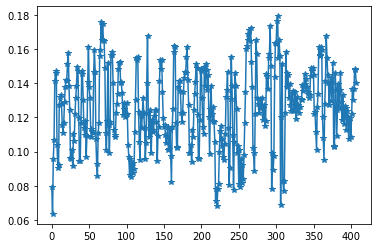

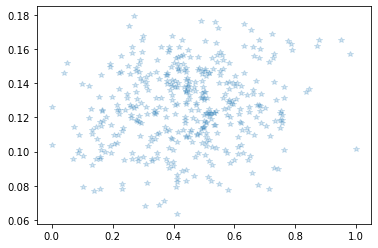

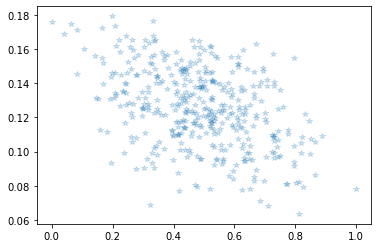

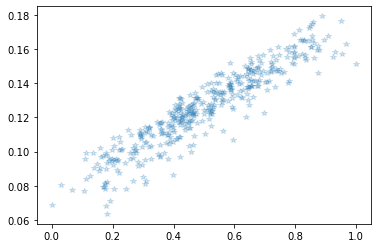

In [293]:
key = "x_c0"
a = 0.2
plt.plot(range(len(local_df[key])), local_df[key], "-*")
plt.show()
plt.plot(df["r2_scaled"], local_df[key], "*", alpha=a)
plt.show()
plt.plot(df["r3_scaled"], local_df[key], "*", alpha=a)
plt.show()
plt.plot(df["a3_scaled"], local_df[key], "*", alpha=a)
plt.show()
# plt.plot(df["bond_sum"], local_df[key], "*", alpha=a)

In [24]:
df

,frame,O,H1,H2,r2,r3,a3,bond_sum,bond_sum_scaled,bond_sum_norm,a3_scaled,a3_norm,r2_scaled,r2_norm,r3_scaled,r3_norm
0,frame_169\n,"[0.0, 0.24292, 0.0]","[1.28597, -0.876276, 0.0]","[-1.28597, -1.067083, 0.0]",0.902137,0.971415,93.436118,1.873552,0.056652,0.911089,0.059235,4.086502,0.000000,-0.106109,0.588311,-0.027524
1,frame_170\n,"[0.0, 0.257757, 0.0]","[1.373172, -0.928284, 0.0]","[-1.373172, -1.133771, 0.0]",0.960175,1.034531,93.801650,1.994706,0.880867,1.042284,0.074862,4.089657,0.364202,-0.041120,1.000000,0.036134
2,frame_171\n,"[0.0, 0.229048, 0.0]","[1.360723, -0.821822, 0.0]","[-1.360723, -1.010558, 0.0]",0.909799,0.974058,99.988294,1.883857,0.126758,0.922209,0.339347,4.141184,0.048080,-0.097156,0.605552,-0.025066
3,frame_172\n,"[0.0, 0.225966, 0.0]","[1.515884, -0.837702, 0.0]","[-1.515884, -0.970028, 0.0]",0.979949,1.021778,106.670822,2.001727,0.928633,1.049917,0.625033,4.193219,0.488289,-0.020374,0.916818,0.022412
4,frame_173\n,"[0.0, 0.198653, 0.0]","[1.482109, -0.776328, 0.0]","[-1.482109, -0.812892, 0.0]",0.938784,0.949555,112.348056,1.888339,0.157247,0.927048,0.867741,4.234813,0.229967,-0.064335,0.445726,-0.047179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,frame_266\n,"[0.0, 0.227601, 0.0]","[1.38954, -0.97422, 0.0]","[-1.38954, -0.84659, 0.0]",0.972188,0.929411,101.437287,1.901600,0.247462,0.941373,0.401294,4.152770,0.439591,-0.028436,0.314334,-0.064265
98,frame_267\n,"[0.0, 0.235306, 0.0]","[1.436324, -0.973205, 0.0]","[-1.436324, -0.909243, 0.0]",0.993321,0.971875,101.373088,1.965196,0.680110,1.010238,0.398549,4.152261,0.572205,-0.006714,0.591311,-0.027097
99,frame_268\n,"[0.0, 0.232393, 0.0]","[1.436399, -0.927684, 0.0]","[-1.436399, -0.931458, 0.0]",0.977048,0.978304,102.058333,1.955351,0.613138,0.999560,0.427844,4.157683,0.470085,-0.023376,0.633245,-0.021082
100,frame_269\n,"[0.0, 0.224394, 0.0]","[1.400685, -0.861684, 0.0]","[-1.400685, -0.933467, 0.0]",0.937926,0.961671,102.631869,1.899596,0.233832,0.939208,0.452363,4.162192,0.224582,-0.065284,0.524752,-0.036431
